In [133]:
from matplotlib.ticker import FuncFormatter
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as w
import pandas as pd
import numpy as np
import math as m
sns.set_style('darkgrid')
w.filterwarnings('ignore')

In [149]:
pd.set_option('display.precision', 10)

# Experimento de Absorção de Raios-X

$C$: Contagem (número de pulsos).\
$\Delta t$: tempo de contagem.\
$R_c$: taxa de contagem corrigida levando-se em conta a radiação de fundo e “tempo morto” do contador.\
$R_{\text{fundo}}$: taxa de contagem da radiação de fundo.\
$e$: espessura da placa absorvedora.\
$\theta$: ângulo de Bragg.\
$tcoef$ : taxa de transmissão, onde $R_c (e)$ e $R_c (0)$ são as taxas de contagem corrigidas, obtidas para a lâmina de espessura e na ausência de lâmina.\
$ln(tcoef)$: logaritmo neperiano do coeficiente de transmissão.\
$\mu (e)$: coeficiente de atenuação linear para a espessura $e$.\
$\rho$: densidade do material absorvedor.\
$\frac{\mu (e)}{\rho}$: coeficiente mássico de absorção.

$$tcoef(e) = \frac{R_c (e)}{R_{c} (0)}$$

$$\lambda = 2 d sen \theta$$

$$R_c = \frac{1}{\frac{\Delta t}{C} - \tau} - \frac{1}{\frac{1}{R_{\text{fundo}}} - \tau}$$

$$\mu (e) = \left(\frac{1}{e}\right) ln\left(\frac{R_c (0)}{R_c (e)}\right)$$

onde $\tau = 100\ \mu s$ é o “tempo morto" do tubo contador.

# Dados globais e funções

In [134]:
def linear_regression(series_X, series_Y):
    """
    Perform linear regression on two series.

    Parameters:
    - series_X (pd.Series): The independent variable series.
    - series_Y (pd.Series): The dependent variable series.

    Returns:
    tuple: A tuple containing the results of the linear regression.
        - slope (float): Slope of the regression line.
        - intercept (float): Intercept of the regression line.
        - r_value (float): Correlation coefficient (R-value).
        - p_value (float): Two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero.
        - std_err (float): Standard error of the estimated gradient.
    """
    result = linregress(series_X, series_Y)
    return result.slope, result.intercept, result.rvalue, result.pvalue, result.stderr

def float_formatter(x, pos):
    """
    Format a floating-point number with one decimal place.

    Parameters:
    - x (float): The floating-point number to be formatted.
    - pos (int): The tick position (ignored in this function).

    Returns:
    str: A formatted string representation of the floating-point number with one decimal place.
    """
    return f"{x:.1f}"

def float_formatter_aux(x, pos):
    """
    Format a floating-point number with one decimal place.

    Parameters:
    - x (float): The floating-point number to be formatted.
    - pos (int): The tick position (ignored in this function).

    Returns:
    str: A formatted string representation of the floating-point number with one decimal place.
    """
    return f"{x:.2f}"

def absorption_coef(e, R_0_series, R_c_series, rho=2.699):
    """
    Calculate the absorption coefficient for a material.

    Parameters:
    - e (pd.Series): Thickness of the material in millimeters.
    - R_0_series (pd.Series): Series of uncorrected count rates in counts per second.
    - R_c_series (pd.Series): Series of corrected count rates for the given thickness e in counts per second.
    - rho (float, optional): Density of the material in grams per cubic centimeter (default is for the aluminum: 2.699).

    Returns:
    pd.Series: Absorption coefficients.
    """
    return (((1 / e) * m.log(R_0_series / R_c_series)) / rho)

def lamb(theta, d=201.4 * 1e-12):
    """
    Calculate the wavelength of X-rays using Bragg's law.

    Parameters:
    - theta (float): Angle of incidence in degrees.
    - d (float, optional): Interplanar spacing of the crystal lattice. Default is 201.4 picometers (pm).

    Returns:
    float: Wavelength of X-rays in meters.
    """
    return 2 * d * m.sin(m.radians(theta))

def R_c(delta_t, C, R_back=29 / 100, tau=1e-4):
    """
    Calculate the corrected count rate (R_c) based on experimental parameters.

    Parameters:
    - delta_t (float): Time interval for counting in seconds.
    - C (float): Counting rate (number of pulses).
    - tau (float, optional): Dead time of the counting tube in seconds. Default is 1e-4 seconds.
    - R_back (float, optional): Background count rate in counts per second. Default is 29/100.

    Returns:
    float: Corrected count rate (R_c) in counts per second.
    """
    return (1 / ((delta_t / C) - tau)) - (1 / ((1 / R_back) - tau))

def tcoef(R_c_series):
    """
    Calculate the transmission coefficient (tcoef) based on corrected count rates.

    Parameters:
    - R_c_series (pd.Series): Series containing corrected count rates.

    Returns:
    pd.Series: Transmission coefficients (tcoef) dimensionless.
    """
    R_c_0 = R_c_series.iloc[0]
    return R_c_series / R_c_0

def ln_tcoef(R_c_series):
    """
    Calculate the natural logarithm of the transmission coefficient.

    Parameters:
    - R_c_series (pd.Series): Series containing corrected count rates.

    Returns:
    pd.Series: Natural logarithm of the transmission coefficient.
    """
    tcoef_series = tcoef(R_c_series)
    return tcoef_series.apply(lambda x: m.log(x) if x > 0 else float('nan'))

In [135]:
U_A = 25. # [kV]

## Determinação da atenuação em função da espessura $\rightarrow$ Alumínio

### Dados - Djalma

In [137]:
djalma_table_1 = pd.DataFrame(
    {
        'e [mm]' : np.arange(.0, .18, 0.02),
        'Δ_t_1 [s]' : np.ones(9),
        'C_1' : [2098, 2834, 2761, 2508, 1911, 2027, 1601, 1268, 1020],
        'Δ_t_2 [s]' : np.ones(9) * 10.,
        'C_2' : [3376, 3147, 2809, 2691, 2330, 2361, 2214, 1991, 1896]
    }
)

In [138]:
djalma_table_1['R_c_1 [s⁻¹]'] = djalma_table_1.apply(
    lambda row: R_c(row['Δ_t_1 [s]'], row['C_1']),
    axis=1
)

djalma_table_1['R_c_2 [s⁻¹]'] = djalma_table_1.apply(
    lambda row: R_c(row['Δ_t_2 [s]'], row['C_2']),
    axis=1
)

djalma_table_1['tcoef_1'] = tcoef(djalma_table_1['R_c_1 [s⁻¹]'])
djalma_table_1['tcoef_2'] = tcoef(djalma_table_1['R_c_1 [s⁻¹]'])

djalma_table_1['ln(tcoef_1)'] = ln_tcoef(djalma_table_1['R_c_1 [s⁻¹]'])
djalma_table_1['ln(tcoef_2)'] = ln_tcoef(djalma_table_1['R_c_2 [s⁻¹]'])

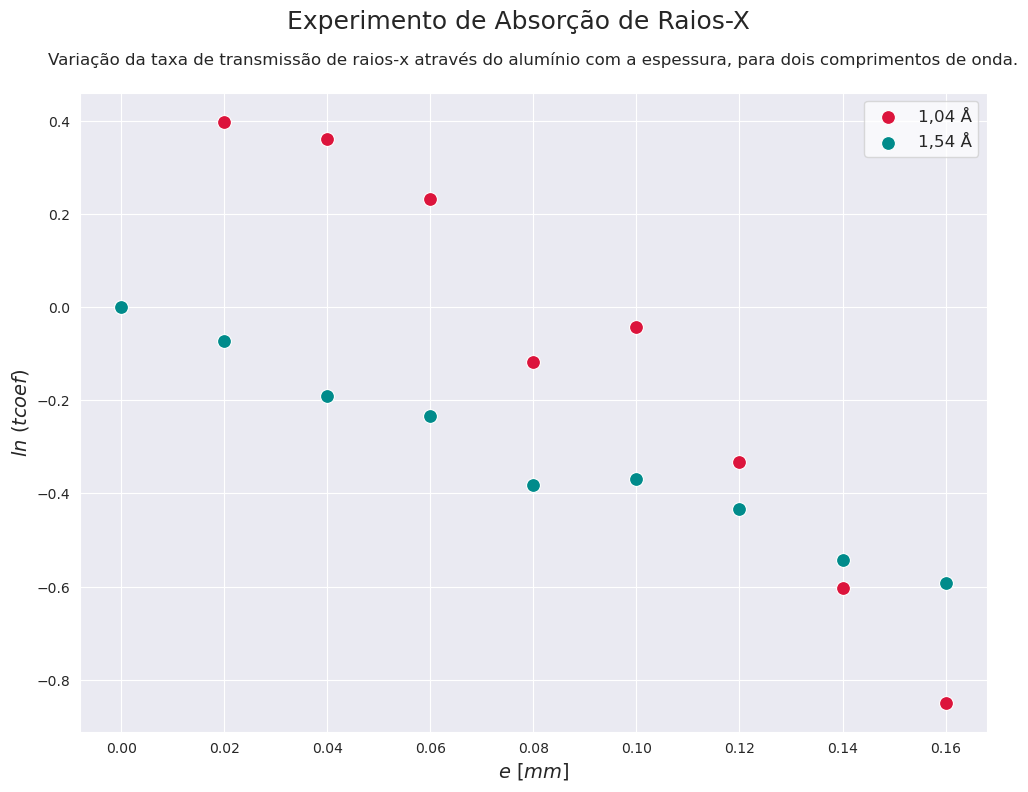

In [139]:
f = plt.figure(figsize=(11.7, 8.3))
plt.suptitle('Experimento de Absorção de Raios-X', fontsize=18)
plt.title('Variação da taxa de transmissão de raios-x através do alumínio com a espessura, para dois comprimentos de onda.', y=1.03, fontsize=12)
sns.scatterplot(x='e [mm]', y='ln(tcoef_1)', data=djalma_table_1, s=100, label='1,04 Å', color='crimson') 
sns.scatterplot(x='e [mm]', y='ln(tcoef_2)', data=djalma_table_1, s=100, label='1,54 Å', color='darkcyan')
plt.xlabel(r'$e\ [mm]$', fontsize=14)
plt.ylabel(r'$ln\ (tcoef)$', fontsize=14)
plt.legend(frameon=True, facecolor='white', framealpha=0.7, fontsize='large')
plt.savefig('ln(tcoef)_X_e_Djalma.pdf')
plt.show()

In [140]:
_, _, r_value_1, _, _ = linear_regression(djalma_table_1['e [mm]'], djalma_table_1['ln(tcoef_1)'])
_, _, r_value_2, _, _ = linear_regression(djalma_table_1['e [mm]'], djalma_table_1['ln(tcoef_2)'])

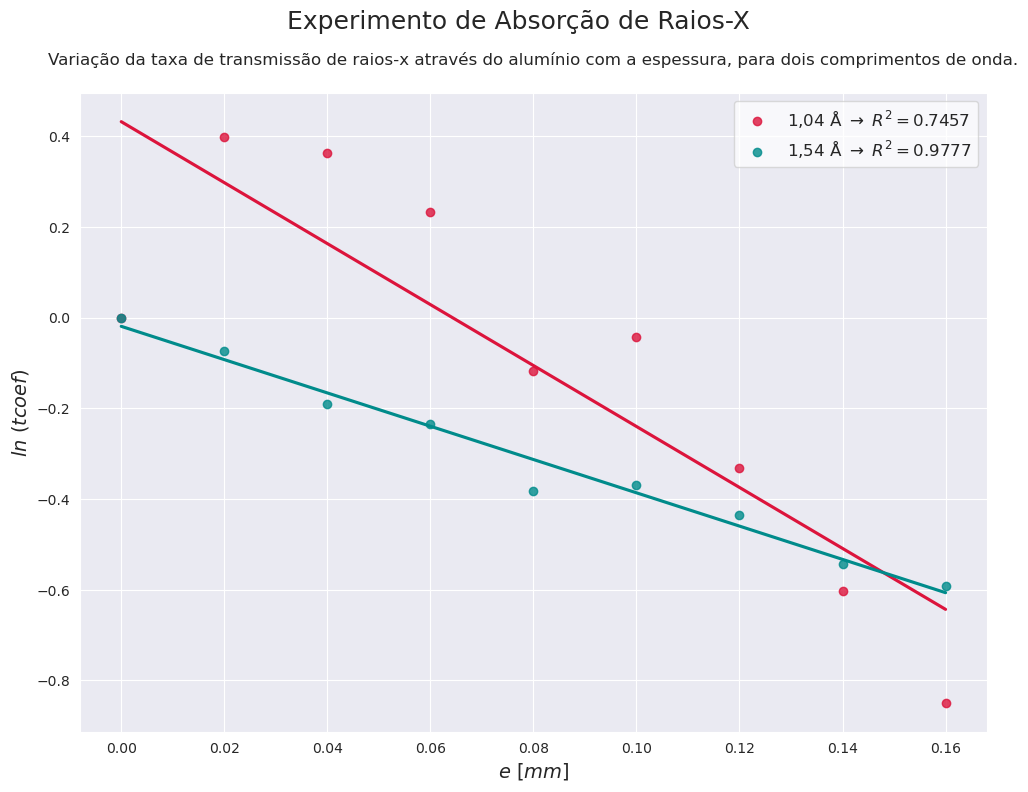

In [141]:
f = plt.figure(figsize=(11.7, 8.3))
plt.suptitle('Experimento de Absorção de Raios-X', fontsize=18)
plt.title('Variação da taxa de transmissão de raios-x através do alumínio com a espessura, para dois comprimentos de onda.', y=1.03, fontsize=12)
sns.regplot(x='e [mm]', y='ln(tcoef_1)', data=djalma_table_1, label=fr'1,04 Å $\rightarrow$ $R^2 = {r_value_1 ** 2:.4f}$', color='crimson', ci=None) 
sns.regplot(x='e [mm]', y='ln(tcoef_2)', data=djalma_table_1, label=fr'1,54 Å $\rightarrow$ $R^2 = {r_value_2 ** 2:.4f}$', color='darkcyan', ci=None)
plt.xlabel(r'$e\ [mm]$', fontsize=14)
plt.ylabel(r'$ln\ (tcoef)$', fontsize=14)
plt.legend(frameon=True, facecolor='white', framealpha=0.7, fontsize='large')
plt.savefig('regplot_ln(tcoef)_X_e_Djalma.pdf')
plt.show()

In [142]:
djalma_table_2 = pd.DataFrame(
    {
        'theta [°]' : np.arange(8, 21, 1),
        'lambda [pm]' : [lamb(theta) * 1e12 for theta in np.arange(8, 21, 1)],
        'e_1 [mm]' : np.array([.0] * 13),
        'Δ_t_1 [s]' : np.array([10] * 12 + [1]),
        'C_1' : [1380, 2330, 2965, 3410, 3732, 3953, 3283, 3277, 3285, 2986, 2852, 2765, 1374],
        'e_2 [mm]' : np.array([.08] * 13),
        'Δ_t_2 [s]' : np.array([60] + [10] * 12),
        'C_2' : [7951, 2410, 2830, 3050, 3270, 3085, 2437, 2329, 2093, 1866, 1591, 1473, 6016],
    }
)

In [143]:
djalma_table_2['R_c_0 [s⁻¹]'] = djalma_table_2.apply(
    lambda row: R_c(row['Δ_t_1 [s]'], row['C_1']),
    axis=1
)

djalma_table_2['R_c_e [s⁻¹]'] = djalma_table_2.apply(
    lambda row: R_c(row['Δ_t_2 [s]'], row['C_2']),
    axis=1
)

djalma_table_2['absorption_coef [cm² / g]'] = djalma_table_2.apply(
    lambda row: absorption_coef(row['e_2 [mm]'], row['R_c_0 [s⁻¹]'], row['R_c_e [s⁻¹]']) * 10,
    axis=1
)

djalma_table_2['absorption_coef_exp_(1/3) [cm² / g]^(1/3)'] = djalma_table_2['absorption_coef [cm² / g]'].apply(lambda element: element**(1 / 3))

filtered_y = djalma_table_2[~djalma_table_2['absorption_coef_exp_(1/3) [cm² / g]^(1/3)'].apply(np.iscomplex)]

In [144]:
djalma_table_2

,theta [°],lambda [pm],e_1 [mm],Δ_t_1 [s],C_1,e_2 [mm],Δ_t_2 [s],C_2,R_c_0 [s⁻¹],R_c_e [s⁻¹],absorption_coef [cm² / g],absorption_coef_exp_(1/3) [cm² / g]^(1/3)
0,8,56.0589,0.0,10,1380,0.08,60,7951,139.6410,134.0063,1.9076,1.2402+0.0000j
1,9,63.0118,0.0,10,2330,0.08,10,2410,238.2684,246.6615,-1.6033,0.5852+1.0136j
2,10,69.9455,0.0,10,2965,0.08,10,2830,305.2698,290.9521,2.2248,1.3055+0.0000j
3,11,76.8579,0.0,10,3410,0.08,10,3050,352.7486,314.3051,5.3442,1.7483+0.0000j
4,12,83.7468,0.0,10,3732,0.08,10,3270,387.3778,337.7644,6.3473,1.8515+0.0000j
5,13,90.6103,0.0,10,3953,0.08,10,3085,411.2793,318.0302,11.9084,2.2836+0.0000j
6,14,97.4461,0.0,10,3283,0.08,10,2437,339.1539,249.4973,14.2185,2.4226+0.0000j
7,15,104.2523,0.0,10,3277,0.08,10,2329,338.5126,238.1636,16.2840,2.5347+0.0000j
8,16,111.0267,0.0,10,3285,0.08,10,2093,339.3677,213.4843,21.4673,2.7792+0.0000j
9,17,117.7673,0.0,10,2986,0.08,10,1866,307.5006,189.8582,22.3323,2.8161+0.0000j


In [ ]:
djalma_table_2.to_excel('AbsorcaoRaioX_tabela_3a.xlsx', sheet_name='preprocessed_data')

In [ ]:
f = plt.figure(figsize=(11.7, 8.3))
plt.suptitle(r'Experimento de absorção de raios-X', fontsize=18) 
plt.title(r'Dependência, com o comprimento de onda $\lambda$, do coeficiente mássico $\mu / \rho$ de absorção de raios-x (produzido por anodo de cobre, sob tensão $U_A = 25.0\ kV$), pelo alumínio $0.08\ mm$ de espessura.', y=1.02, fontsize=10)  
sns.scatterplot(x='lambda [pm]', y='absorption_coef_exp_(1/3) [cm² / g]^(1/3)', data=filtered_y, s=100, color='crimson', marker='s') 
plt.xlabel(r'$\lambda\ (pm)$', fontsize=16)
plt.ylabel(r'$\left(\frac{\mu}{\rho}\right)^{\frac{1}{3}}\ (cm^2 / g)^{\frac{1}{3}}$', fontsize=16)
plt.gca().xaxis.set_major_formatter(FuncFormatter(float_formatter))
plt.savefig('tabela_3a_ln(tcoef)_X_e.pdf')
plt.show()

In [ ]:
_, _, r_value, _, _ = linear_regression(djalma_table_2['lambda [pm]'], djalma_table_2['absorption_coef_exp_(1/3) [cm² / g]^(1/3)'])

In [ ]:
f = plt.figure(figsize=(11.7, 8.3))
plt.suptitle(r'Dependência $\lambda$ do coeficiente mássico $\frac{\mu}{\rho}$ de absorção de raios-X', fontsize=18) 
plt.title(r'Produzido por anodo de cobre, sob tensão $U_A = 25.0\ kV$, pelo alumínio $0.08\ mm$ de espessura.', y=1.02, fontsize=12)  
sns.regplot(x='lambda [pm]', y='absorption_coef_exp_(1/3) [cm² / g]^(1/3)', data=filtered_y, color='darkviolet', label=fr'$R^2 = {r_value.real ** 2:.4f}$') 
plt.xlabel(r'$\lambda\ (pm)$', fontsize=16)
plt.ylabel(r'$\left(\frac{\mu}{\rho}\right)^{\frac{1}{3}}\ (cm^2 / g)^{\frac{1}{3}}$', fontsize=16)
plt.legend(frameon=True, facecolor='white', framealpha=0.7, fontsize='large')
plt.gca().xaxis.set_major_formatter(FuncFormatter(float_formatter))
plt.show()

### Dados - Nosso grupo

#### Tabela 2a

In [ ]:
tabela_2a = pd.DataFrame(
    {
        'e [mm]' : np.arange(.0, .18, 0.02),
        'Δ_t_1 [s]' : np.ones(9),
        'C_1' : [1606, 2633, 2767, 2596, 2063, 2179, 1834, 1367, 1167],
        'Δ_t_2 [s]' : np.array([10] * 8 + [60]),
        'C_2' : [3003, 2784, 2447, 2321, 2028, 2131, 1893, 1610, 9526]
    }
)

In [ ]:
tabela_2a['R_c_1 [s⁻¹]'] = tabela_2a.apply(
    lambda row: R_c(row['Δ_t_1 [s]'], row['C_1'], 26 / 100),
    axis=1
)

tabela_2a['R_c_2 [s⁻¹]'] = tabela_2a.apply(
    lambda row: R_c(row['Δ_t_2 [s]'], row['C_2'], 26 / 100),
    axis=1
)

tabela_2a['ln(tcoef_1)'] = ln_tcoef(tabela_2a['R_c_1 [s⁻¹]'])
tabela_2a['ln(tcoef_2)'] = ln_tcoef(tabela_2a['R_c_2 [s⁻¹]'])

In [ ]:
tabela_2a

In [ ]:
tabela_2a.to_excel('AbsorcaoRaioX_tabela_2a.xlsx', sheet_name='preprocessed_data')

In [ ]:
f = plt.figure(figsize=(11.7, 8.3))
plt.suptitle('Experimento de Absorção de Raios-X', fontsize=18)
plt.title('Dependência, com a espessura, da taxa de transmissão de raios-x no alumínio, para dois comprimentos de onda (1,04 Å e 1,54 Å).', y=1.03, fontsize=12)
sns.scatterplot(x='e [mm]', y='ln(tcoef_1)', data=tabela_2a, s=100, label='1,04 Å', color='crimson', marker='s') 
sns.scatterplot(x='e [mm]', y='ln(tcoef_2)', data=tabela_2a, s=100, label='1,54 Å', color='darkcyan')
plt.xlabel(r'$e\ [mm]$', fontsize=14)
plt.ylabel(r'$ln\ (tcoef)$', fontsize=14)
plt.legend(frameon=True, facecolor='white', framealpha=0.7, fontsize='large')
plt.gca().xaxis.set_major_formatter(FuncFormatter(float_formatter_aux))
plt.gca().yaxis.set_major_formatter(FuncFormatter(float_formatter))
plt.savefig('tabela_2a_ln(tcoef)_X_e.pdf')
plt.show()

In [ ]:
_, _, r_value_1, _, _ = linear_regression(tabela_2a['e [mm]'], tabela_2a['ln(tcoef_1)'])
_, _, r_value_2, _, _ = linear_regression(tabela_2a['e [mm]'], tabela_2a['ln(tcoef_2)'])

In [ ]:
f = plt.figure(figsize=(11.7, 8.3))
plt.suptitle('Experimento de Absorção de Raios-X', fontsize=18)
plt.title('Variação da taxa de transmissão de raios-x através do alumínio com a espessura, para dois comprimentos de onda.', y=1.03, fontsize=12)
sns.regplot(x='e [mm]', y='ln(tcoef_1)', data=tabela_2a, label=fr'1,04 Å $\rightarrow$ $R^2 = {r_value_1 ** 2:.4f}$', color='crimson', ci=None) 
sns.regplot(x='e [mm]', y='ln(tcoef_2)', data=tabela_2a, label=fr'1,54 Å $\rightarrow$ $R^2 = {r_value_2 ** 2:.4f}$', color='darkcyan', ci=None)
plt.xlabel(r'$e\ [mm]$', fontsize=14)
plt.ylabel(r'$ln\ (tcoef)$', fontsize=14)
plt.legend(frameon=True, facecolor='white', framealpha=0.7, fontsize='large')
plt.savefig('regplot_ln(tcoef)_X_e.pdf')
plt.show()

#### Tabela 2b

In [ ]:
tabela_2b = pd.DataFrame(
    {
        'e [mm]' : np.arange(.0, .125, .025),
        'Δ_t [s]' : np.array([1] * 3 + [10] * 2),
        'C' : [1425, 2556, 1327, 5593, 2228],
    }
)

In [ ]:
tabela_2b['R_c [s⁻¹]'] = tabela_2b.apply(
    lambda row: R_c(row['Δ_t [s]'], row['C'], 26 / 100),
    axis=1
)

tabela_2b['ln(tcoef)'] = ln_tcoef(tabela_2b['R_c [s⁻¹]'])

In [ ]:
tabela_2b

In [ ]:
tabela_2b.to_excel('AbsorcaoRaioX_tabela_2b.xlsx', sheet_name='preprocessed_data')

In [ ]:
f = plt.figure(figsize=(11.7, 8.3))
plt.suptitle('Experimento de Absorção de Raios-X', fontsize=18)
plt.title('Dependência, com a espessura, da taxa de transmissão de raios-x no zinco, para o comprimento de onda 1,54 Å.', y=1.03, fontsize=12)
sns.scatterplot(x='e [mm]', y='ln(tcoef)', data=tabela_2b, s=100, label='1,54 Å', color='crimson', marker='s') 
plt.xlabel(r'$e\ [mm]$', fontsize=14)
plt.ylabel(r'$ln\ (tcoef)$', fontsize=14)
plt.legend(frameon=True, facecolor='white', framealpha=0.7, fontsize='large')
plt.gca().xaxis.set_major_formatter(FuncFormatter(float_formatter_aux))
plt.gca().yaxis.set_major_formatter(FuncFormatter(float_formatter))
plt.savefig('tabela_2b_ln(tcoef)_X_e.pdf')
plt.show()

#### Tabela 3b

In [150]:
tabela_3b = pd.DataFrame(
    {
        'theta [°]' : np.arange(8, 21, 1),
        'lambda [pm]' : [lamb(theta) * 1e12 for theta in np.arange(8, 21, 1)],
        'e_1 [mm]' : np.array([.0] * 13),
        'Δ_t_1 [s]' : np.array([10] * 12 + [1]),
        'C_1' : [2037, 2666, 3246, 3605, 3957, 3983, 3257, 3335, 3282, 2964, 2784, 2714, 1299],
        'e_2 [mm]' : np.array([.0025] * 13),
        'Δ_t_2 [s]' : np.array([60] * 13),
        'C_2' : [5390, 8472, 9403, 9099, 8340, 6923, 4378, 3536, 2976, 2463, 2084, 1764, 2842],
    }
)

In [151]:
tabela_3b['R_c_0 [s⁻¹]'] = tabela_3b.apply(
    lambda row: R_c(row['Δ_t_1 [s]'], row['C_1']),
    axis=1
)

tabela_3b['R_c_e [s⁻¹]'] = tabela_3b.apply(
    lambda row: R_c(row['Δ_t_2 [s]'], row['C_2']),
    axis=1
)

tabela_3b['absorption_coef [cm² / g]'] = tabela_3b.apply(
    lambda row: absorption_coef(row['e_2 [mm]'], row['R_c_0 [s⁻¹]'], row['R_c_e [s⁻¹]'], 7.2984),
    axis=1
)

tabela_3b['absorption_coef_exp_(1/3) [cm² / g]^(1/3)'] = tabela_3b['absorption_coef [cm² / g]'].apply(lambda element: element**(1 / 3))

filtered_y = tabela_3b[~tabela_3b['absorption_coef_exp_(1/3) [cm² / g]^(1/3)'].apply(np.iscomplex)]

In [152]:
tabela_3b

,theta [°],lambda [pm],e_1 [mm],Δ_t_1 [s],C_1,e_2 [mm],Δ_t_2 [s],C_2,R_c_0 [s⁻¹],R_c_e [s⁻¹],absorption_coef [cm² / g],absorption_coef_exp_(1/3) [cm² / g]^(1/3)
0,8,56.0589250667,0.0,10,2037,0.0025,60,5390,207.6456407634,90.3576429915,45.6021796585,3.5726888979
1,9,63.0118025182,0.0,10,2666,0.0025,60,8472,273.6122251361,142.9322904497,35.5881202728,3.2892863532
2,10,69.9454859642,0.0,10,3246,0.0025,60,9403,335.1999971709,158.9217722117,40.9029528492,3.4454944433
3,11,76.8578633377,0.0,10,3605,0.0025,60,9099,373.6920446008,153.6951769254,48.6934548839,3.6516588415
4,12,83.7468290614,0.0,10,3957,0.0025,60,8340,411.7129485986,140.6693263428,58.8575275118,3.8898603032
5,13,90.6102846897,0.0,10,3983,0.0025,60,6923,414.5323667941,116.4401969425,69.5918693215,4.1132600495
6,14,97.4461395475,0.0,10,3257,0.0025,60,4378,336.3751766677,73.2129850991,83.5719794453,4.3720678815
7,15,104.2523113673,0.0,10,3335,0.0025,60,3536,344.7159399682,58.9926976709,96.7503588466,4.5907558343
8,16,111.0267269231,0.0,10,3282,0.0025,60,2976,339.0470332986,49.5572339117,105.3935436133,4.7235806584
9,17,117.7673226623,0.0,10,2964,0.0025,60,2463,305.1636376593,40.9291964256,110.1065708776,4.7929667086


In [155]:
tabela_3b.to_excel('AbsorcaoRaioX_tabela_3b.xlsx', sheet_name='preprocessed_data')

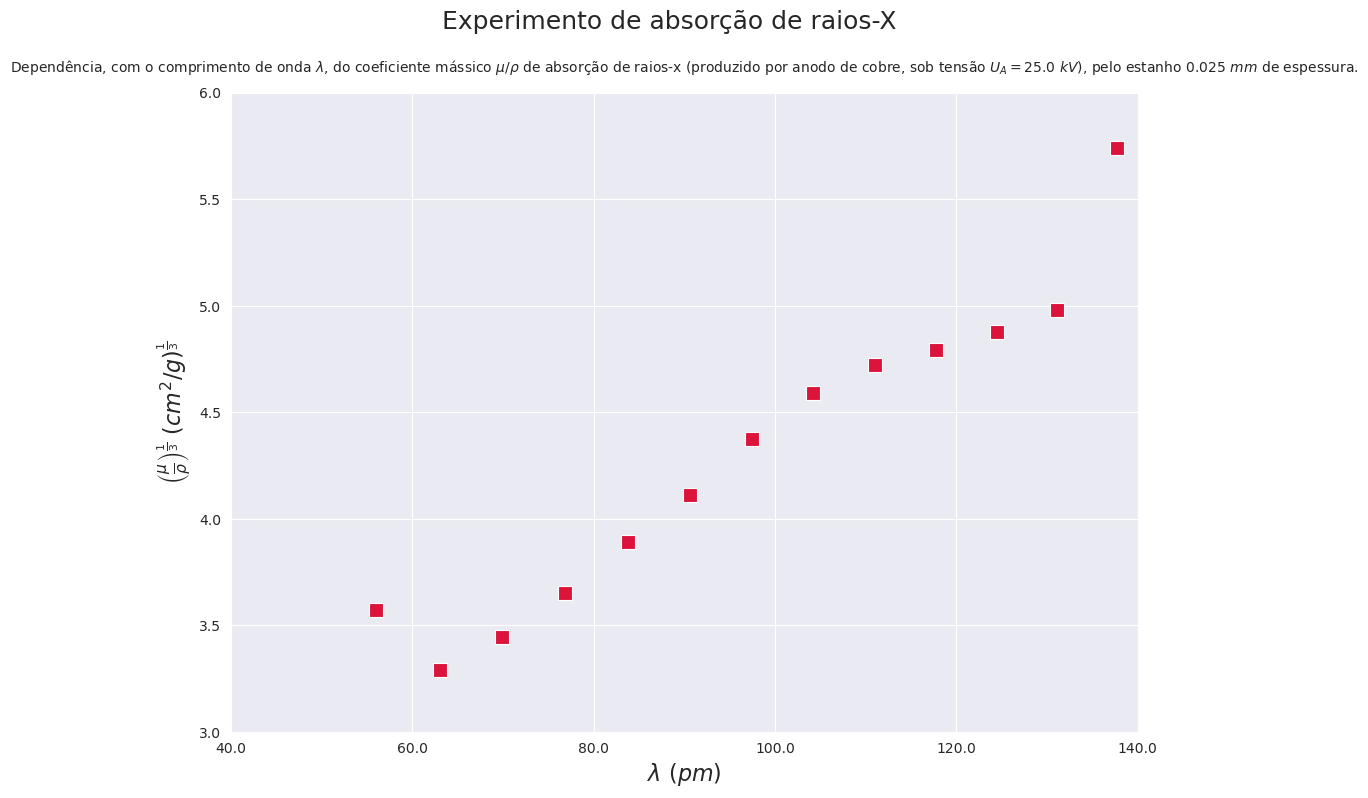

In [154]:
f = plt.figure(figsize=(11.7, 8.3))
plt.suptitle(r'Experimento de absorção de raios-X', fontsize=18) 
plt.title(r'Dependência, com o comprimento de onda $\lambda$, do coeficiente mássico $\mu / \rho$ de absorção de raios-x (produzido por anodo de cobre, sob tensão $U_A = 25.0\ kV$), pelo estanho $0.025\ mm$ de espessura.', y=1.02, fontsize=10)  
sns.scatterplot(x='lambda [pm]', y='absorption_coef_exp_(1/3) [cm² / g]^(1/3)', data=filtered_y, s=100, color='crimson', marker='s') 
plt.xlabel(r'$\lambda\ (pm)$', fontsize=16)
plt.ylabel(r'$\left(\frac{\mu}{\rho}\right)^{\frac{1}{3}}\ (cm^2 / g)^{\frac{1}{3}}$', fontsize=16)
plt.gca().xaxis.set_major_formatter(FuncFormatter(float_formatter))
plt.xlim(40, 140)
plt.ylim(3, 6)
plt.savefig('tabela_3b_ln(tcoef)_X_e.pdf')
plt.show()

#### Tabela 3c

In [156]:
tabela_3c = pd.DataFrame(
    {
        'theta [°]' : np.concatenate([np.arange(12, 20, 1), np.arange(19.2, 25.2, 0.2)]),
        'lambda [pm]' : [(lamb(theta) * 1e12) for theta in np.concatenate([np.arange(12, 20, 1), np.arange(19.2, 25.2, 0.2)])],
        'e_1 [mm]' : np.array([.0] * 38),
        'Δ_t_1 [s]' : np.array([100] * 3 + [60] * 10 + [10] * 4 + [60] * 2 + [100] * 4 + [60] + [10] + [1] * 2 + [10] + [60] + [100] * 9),
        'C_1' : [6672, 9748, 9699, 6441, 6973, 6905, 6678, 6737, 6530, 6357, 6125, 5896, 8036, 4480, 5328, 4301, 1932, 6296, 5709, 9361, 9944, 9850, 9375, 6683, 8496, 1846, 1618, 9350, 9175, 6863, 6133, 5673, 5380, 6099, 7475, 6761, 5684, 4301],
        'e_2 [mm]' : np.array([.0025] * 38),
        'Δ_t_2 [s]' : np.array([100] * 13 + [60] + [10] * 2 + [60] * 3 + [100] * 5 + [10] * 4 + [100] * 10),
        'C_2' : [1701, 2041, 1751, 1467, 1246, 953, 750, 651, 577, 580, 535, 544, 1890, 9234, 2180, 1824, 5184, 2568, 2225, 3473, 3576, 3500, 3417, 3488, 2605, 6747, 5982, 3667, 5485, 2052, 1790, 1611, 1469, 1590, 1866, 1725, 1396, 1071],
    }
)

In [157]:
tabela_3c['R_c_0 [s⁻¹]'] = tabela_3c.apply(
    lambda row: R_c(row['Δ_t_1 [s]'], row['C_1']),
    axis=1
)

tabela_3c['R_c_e [s⁻¹]'] = tabela_3c.apply(
    lambda row: R_c(row['Δ_t_2 [s]'], row['C_2']),
    axis=1
)

tabela_3c['absorption_coef [cm² / g]'] = tabela_3c.apply(
    lambda row: absorption_coef(row['e_2 [mm]'], row['R_c_0 [s⁻¹]'], row['R_c_e [s⁻¹]'], 8.96),
    axis=1
)

tabela_3c['absorption_coef_exp_(1/3) [cm² / g]^(1/3)'] = tabela_3c['absorption_coef [cm² / g]'].apply(lambda element: element**(1 / 3))

filtered_y = tabela_3c[~tabela_3c['absorption_coef_exp_(1/3) [cm² / g]^(1/3)'].apply(np.iscomplex)]

In [158]:
tabela_3c.to_excel('AbsorcaoRaioX_tabela_3c.xlsx', sheet_name='preprocessed_data')

In [164]:
tabela_3c

,theta [°],lambda [pm],e_1 [mm],Δ_t_1 [s],C_1,e_2 [mm],Δ_t_2 [s],C_2,R_c_0 [s⁻¹],R_c_e [s⁻¹],absorption_coef [cm² / g],absorption_coef_exp_(1/3) [cm² / g]^(1/3)
0,12.0,83.7468290614,0.0,100,6672,0.0025,100,1701,66.8781374590,16.7489749004,61.8096010255,3.9538359579
1,13.0,90.6102846897,0.0,100,9748,0.0025,100,2041,98.1495807044,20.1617335952,70.6565275623,4.1341296912
2,14.0,97.4461395475,0.0,100,9699,0.0025,100,1751,97.6499108668,17.2507053796,77.3899870682,4.2614911549
3,15.0,104.2523113673,0.0,60,6441,0.0025,100,1467,108.2248991221,14.4015440973,90.0391085448,4.4820537682
4,16.0,111.0267269231,0.0,60,6973,0.0025,100,1246,117.2931707705,12.1855361182,101.0904843500,4.6583998072
5,17.0,117.7673226623,0.0,60,6905,0.0025,100,953,116.1331615710,9.2490823432,112.9559436086,4.8339597431
6,18.0,124.4720453342,0.0,60,6678,0.0025,100,750,112.2627032708,7.2156208117,122.5264935965,4.9667999539
7,19.0,131.1388526153,0.0,60,6737,0.0025,100,651,113.2683965467,6.2242323605,129.5227711572,5.0595905864
8,19.2,132.4674853063,0.0,60,6530,0.0025,100,577,109.7408271838,5.4833228019,133.7683125608,5.1142789970
9,19.4,133.7945039228,0.0,60,6357,0.0025,100,580,106.7945525127,5.5133575420,132.3095145955,5.0956199045


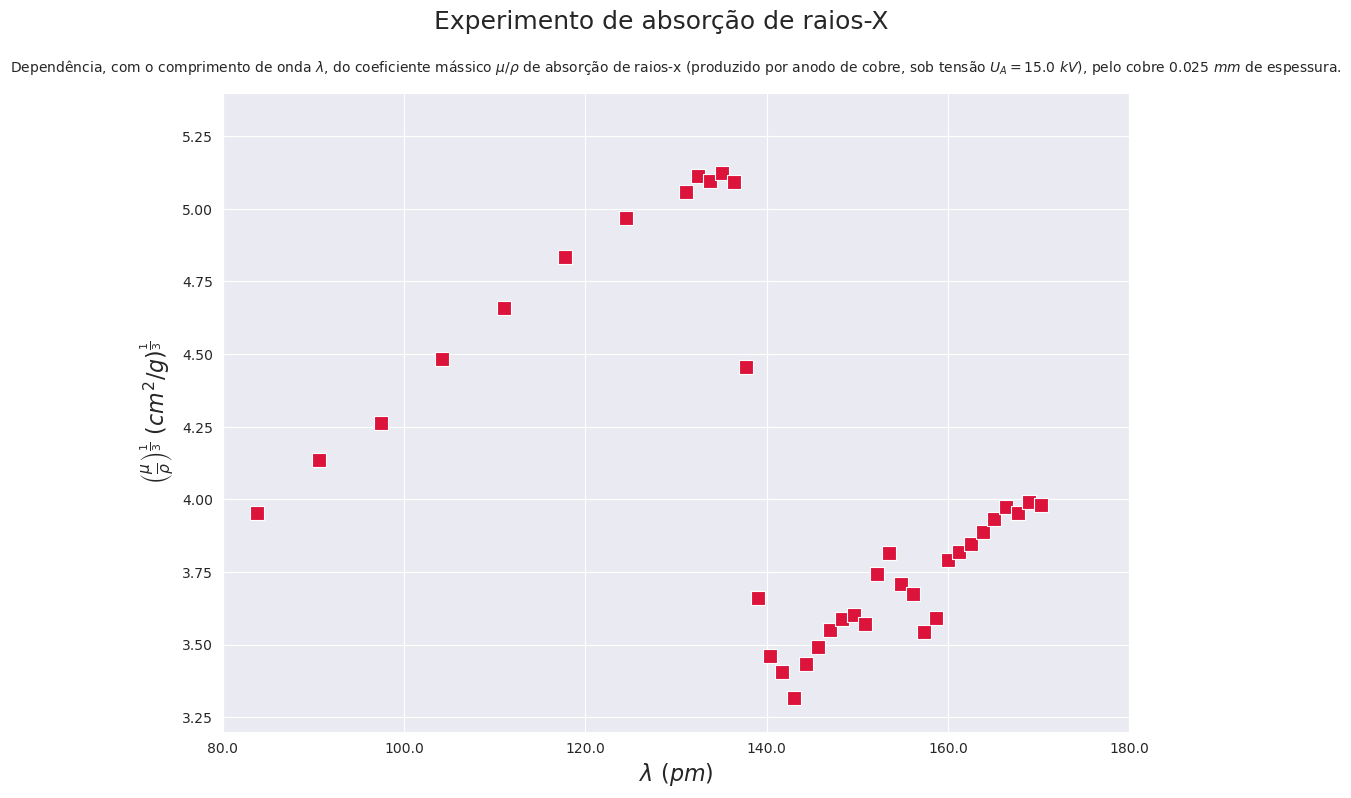

In [165]:
f = plt.figure(figsize=(11.7, 8.3))
plt.suptitle(r'Experimento de absorção de raios-X', fontsize=18) 
plt.title(r'Dependência, com o comprimento de onda $\lambda$, do coeficiente mássico $\mu / \rho$ de absorção de raios-x (produzido por anodo de cobre, sob tensão $U_A = 15.0\ kV$), pelo cobre $0.025\ mm$ de espessura.', y=1.02, fontsize=10)  
sns.scatterplot(x='lambda [pm]', y='absorption_coef_exp_(1/3) [cm² / g]^(1/3)', data=filtered_y, s=100, color='crimson', marker='s') 
plt.xlabel(r'$\lambda\ (pm)$', fontsize=16)
plt.ylabel(r'$\left(\frac{\mu}{\rho}\right)^{\frac{1}{3}}\ (cm^2 / g)^{\frac{1}{3}}$', fontsize=16)
plt.gca().xaxis.set_major_formatter(FuncFormatter(float_formatter))
plt.xlim(80, 180)
plt.ylim(3.2, 5.4)
plt.savefig('tabela_3c_ln(tcoef)_X_e.pdf')
plt.show()

#### Tabela 3d

In [160]:
tabela_3d = pd.read_excel('raw_tabela_3d.xlsx', skiprows=1)
tabela_3d = tabela_3d.apply(lambda x: x.str.replace(',', '.')).astype(float)
tabela_3d['lambda'] = tabela_3d['lambda'] * 1e2
tabela_3d

,teta,lambda,cps0mm,"cps0,025mm",netcps0,"netcps0,025",mabs,root3mabs
0,8.0,56.05892507,135.4,86.90,136.9296456535,87.3361564425,20.2068172680,2.7237420232
1,9.0,63.01180252,222.4,124.20,227.1239691059,125.4338748415,26.6779268389,2.9880236168
2,10.0,69.94548596,294.7,134.70,303.3088045895,136.2103952919,35.9717245136,3.3010625447
3,11.0,76.85786334,323.3,125.70,333.7597731533,126.9719746178,43.4264256273,3.5149409080
4,12.0,83.74682906,364.9,111.70,378.3747880217,112.6345233207,54.4478515825,3.7901836105
5,13.0,90.61028469,365.2,87.40,378.6979300725,87.8449538582,65.6556053230,4.0341985589
6,14.0,97.44613955,317.4,62.95,327.4632032486,63.0247238454,74.0439721803,4.1991678658
7,15.0,104.25231137,329.6,57.37,340.4917110618,57.3773377116,80.0153390197,4.3091447534
8,16.0,111.02672692,315.1,46.62,325.0106863861,46.5153661453,87.3545428099,4.4370586058
9,17.0,117.76732266,299.2,42.25,308.0881382768,42.1065527758,89.4263099895,4.4718624531


In [161]:
tabela_3d.to_excel('AbsorcaoRaioX_tabela_3d.xlsx', sheet_name='preprocessed_data')

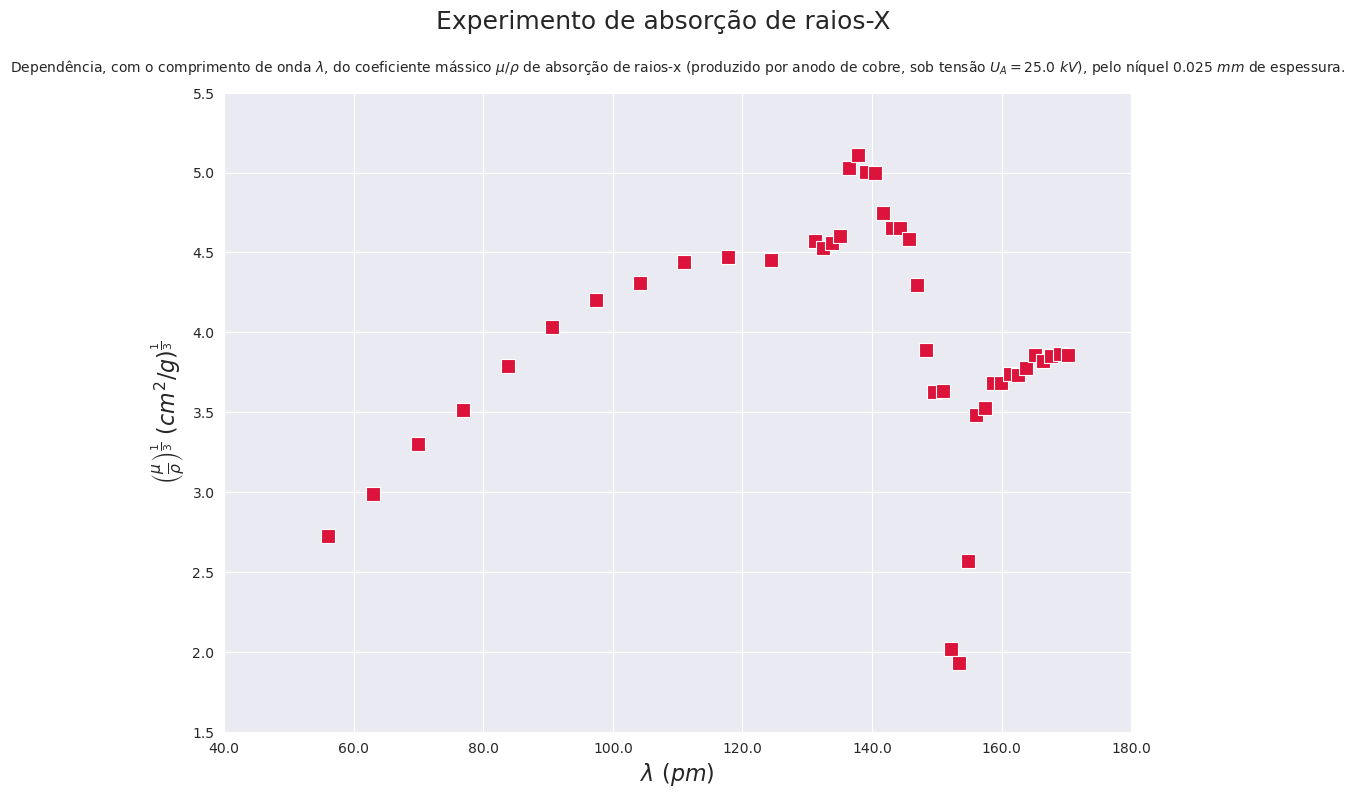

In [163]:
f = plt.figure(figsize=(11.7, 8.3))
plt.suptitle(r'Experimento de absorção de raios-X', fontsize=18) 
plt.title(r'Dependência, com o comprimento de onda $\lambda$, do coeficiente mássico $\mu / \rho$ de absorção de raios-x (produzido por anodo de cobre, sob tensão $U_A = 25.0\ kV$), pelo níquel $0.025\ mm$ de espessura.', y=1.02, fontsize=10)  
sns.scatterplot(x='lambda', y='root3mabs', data=tabela_3d, s=100, color='crimson', marker='s') 
plt.xlabel(r'$\lambda\ (pm)$', fontsize=16)
plt.ylabel(r'$\left(\frac{\mu}{\rho}\right)^{\frac{1}{3}}\ (cm^2 / g)^{\frac{1}{3}}$', fontsize=16)
plt.gca().xaxis.set_major_formatter(FuncFormatter(float_formatter))
plt.xlim(40, 180)
plt.ylim(1.5, 5.5)
plt.savefig('tabela_3d_ln(tcoef)_X_e.pdf')
plt.show()